--2022-12-19 03:17:18--  https://wallpapers.com/images/file/gold-snowy-christmas-tree-outside-m95abzflruoojajb.jpg
Resolving wallpapers.com (wallpapers.com)... 13.35.24.129, 13.35.24.91, 13.35.24.84, ...
Connecting to wallpapers.com (wallpapers.com)|13.35.24.129|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘user_image.jpg’

user_image.jpg          [ <=>                ]   1.57M  --.-KB/s    in 0.03s   

2022-12-19 03:17:18 (53.8 MB/s) - ‘user_image.jpg’ saved [1642136]

--2022-12-19 03:17:18--  https://wallpapers.com/images/file/gold-snowy-christmas-tree-outside-m95abzflruoojajb.jpg
Resolving wallpapers.com (wallpapers.com)... 13.35.24.129, 13.35.24.91, 13.35.24.84, ...
Connecting to wallpapers.com (wallpapers.com)|13.35.24.129|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘style_image.jpg’

style_image.jpg         [ <=>                ]   1.57M  --.-KB/s    

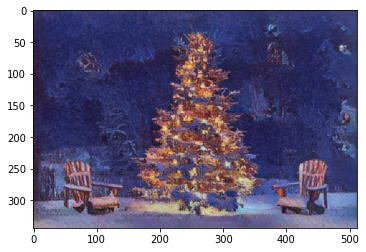

In [ ]:
#Style transfer 
import functools
import os

from matplotlib import gridspec
import IPython.display as display
import matplotlib.pylab as plt
import numpy as np
import PIL.Image
import tensorflow as tf
import tensorflow_hub as hub

#import user image 
! wget https://wallpapers.com/images/file/gold-snowy-christmas-tree-outside-m95abzflruoojajb.jpg -O user_image.jpg

#import style  image 
! wget https://wallpapers.com/images/file/gold-snowy-christmas-tree-outside-m95abzflruoojajb.jpg -O style_image.jpg


#since we are using tensors, need a function to convert back to images for display 
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

#load image with maximum dimensions of 512 
def loadimage(path_to_img):
  max_dim = 512
  image = tf.io.read_file(path_to_img)
  image = tf.image.decode_image(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)

  shape = tf.cast(tf.shape(image)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  image = tf.image.resize(image, new_shape)
  image = image[tf.newaxis, :]
  return image

#load images 
user_image = loadimage('user_image.jpg')
style_image = loadimage('style_image.jpg')

#display image 
def displayimage(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

def styletransfer(user_image, style_image):
  # Load Hub module.
  import tensorflow_hub as hub
  hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
  #create image 
  user_image = loadimage('user_image.jpg')
  style_image = loadimage('style_image.jpg')
  styletransfer_image = hub_model(tf.constant(user_image), tf.constant(style_image))[0]
  tensor_to_image(styletransfer_image)
  displayimage(styletransfer_image)

styletransfer('user_image.jpg', 'style_image.jpg')



In [ ]:
#Model Loss and Optimization 
#build the model 

import functools
import os

from matplotlib import gridspec
import IPython.display as display
import matplotlib.pylab as plt
import numpy as np
import PIL.Image
import tensorflow as tf
import tensorflow_hub as hub

#load vgg19 and choose intermediate layers 
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)

user_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_user_layers = len(user_layers)
num_style_layers = len(style_layers)


def vgg_layers(layer_names):
  """ Creates a VGG model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on ImageNet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

user_image = loadimage('user_image.jpg')
style_image = loadimage('style_image.jpg')

style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

#calculate style 
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, user_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + user_layers)
    self.style_layers = style_layers
    self.user_layers = user_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, user_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    user_dict = {user_name: value
                    for user_name, value
                    in zip(self.user_layers, user_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'user': user_dict, 'style': style_dict}

#extract style 

extractor = StyleContentModel(style_layers, user_layers)

results = extractor(tf.constant(user_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['user'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())


#gradient descent 
style_targets = extractor(style_image)['style']
user_targets = extractor(user_image)['user']

#image to optimize
image = tf.Variable(user_image)

#keep pixel values between 0 and 1 
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

#build an optimizer 
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

#weighted combination of losses 
style_weight=1e-2
user_weight=1e4

#calculate loss 
def style_content_loss(outputs):
    style_outputs = outputs['style']
    user_outputs = outputs['user']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    user_loss = tf.add_n([tf.reduce_mean((user_outputs[name]-user_targets[name])**2) 
                             for name in user_outputs.keys()])
    user_loss *= user_weight / num_user_layers
    loss = style_loss + user_loss
    return loss
  
#update the image 

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

#optimization 
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

#test 
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)
  
end = time.time()
print("Total time: {:.1f}".format(end-start))

#total variation loss - sum of the square of the values 
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

total_variation_loss(image).numpy() 

#tensor flow implementation 
tf.image.total_variation(image).numpy()

#weight for variation 
total_variation_weight=30

#new train 
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))


#re run optimizer 
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
image = tf.Variable(user_image)

import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0

#test 
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

end = time.time()
print("Total time: {:.1f}".format(end-start))



input_3
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool
block1_conv1
  shape:  (1, 341, 512, 64)
  min:  0.0
  max:  811.3067
  mean:  22.29045

block2_conv1
  shape:  (1, 170, 256, 128)
  min:  0.0
  max:  3472.3862
  mean:  114.33465

block3_conv1
  shape:  (1, 85, 128, 256)
  min:  0.0
  max:  6564.911
  mean:  113.747635

block4_conv1
  shape:  (1, 42, 64, 512)
  min:  0.0
  max:  15541.468
  mean:  448.93225

block5_conv1
  shape:  (1, 21, 32, 512)
  min:  0.0
  max:  2347.8223
  mean:  36.481346

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0
    max:  31226.68
    mean:  954.08435

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  186501.36
    mean:  22752.43

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  44735

--2022-12-18 20:30:59--  https://wallpapers.com/images/file/gold-snowy-christmas-tree-outside-m95abzflruoojajb.jpg
Resolving wallpapers.com (wallpapers.com)... 54.192.76.107, 54.192.76.68, 54.192.76.104, ...
Connecting to wallpapers.com (wallpapers.com)|54.192.76.107|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘user_image.jpg’

user_image.jpg          [ <=>                ]   1.57M  --.-KB/s    in 0.06s   

2022-12-18 20:31:00 (24.7 MB/s) - ‘user_image.jpg’ saved [1642136]



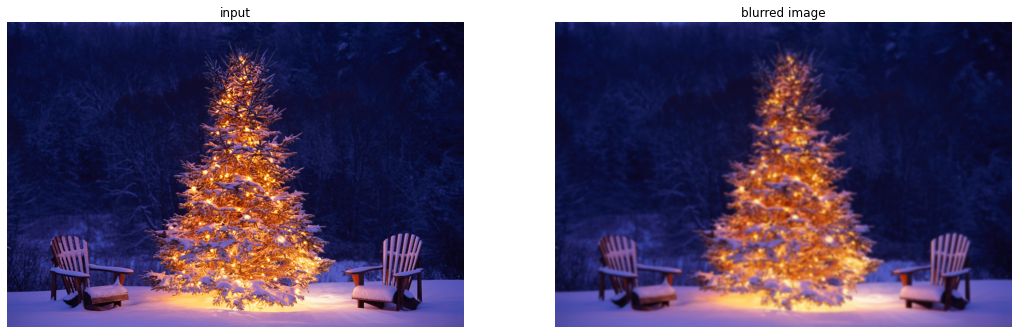

In [ ]:
# Blur filter with user input 
#import image 
! wget https://wallpapers.com/images/file/gold-snowy-christmas-tree-outside-m95abzflruoojajb.jpg -O user_image.jpg
#read image 
from imageio import imread
import matplotlib.pyplot as plt
import numpy as np
import cv2

image = imread('user_image.jpg')

#filter image 
def blurFilter (image,blur_amount):
  blur_image = cv2.GaussianBlur(image, (blur_amount,blur_amount), 0)
  plt.figure(figsize=(18, 8)) 
  plt.subplot(121)
  plt.imshow(image)
  plt.title('input')
  plt.axis('off')
  plt.subplot(122)
  plt.imshow(blur_image)
  plt.title('blurred image')
  plt.axis('off')
 

blurFilter(image, 55)



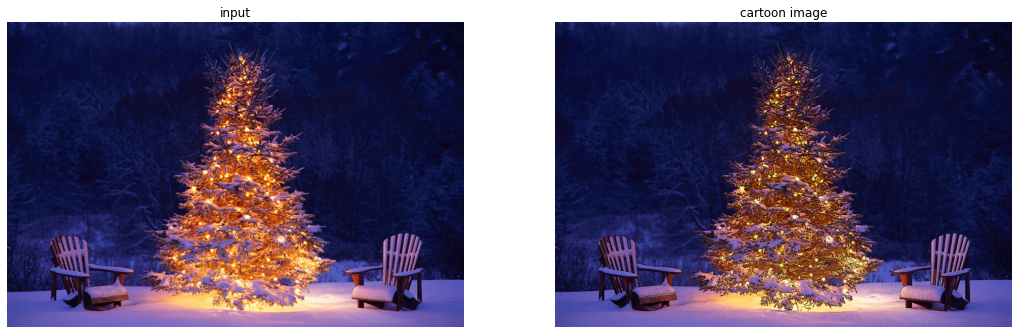

In [ ]:
#Cartoon Filter with User Input 
#filter image
def cartoonFilter (image): 
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  edges = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 9, 9)
  color = cv2.bilateralFilter(image, 9, 200, 200)
  cartoon = cv2.bitwise_and(color, color, mask = edges)
  #display image 
  plt.figure(figsize=(18, 8))
  plt.subplot(121)
  plt.imshow(image)
  plt.title('input')
  plt.axis('off')
  plt.subplot(122)
  plt.imshow(cartoon)
  plt.title('cartoon image')
  plt.axis('off')

cartoonFilter(image)


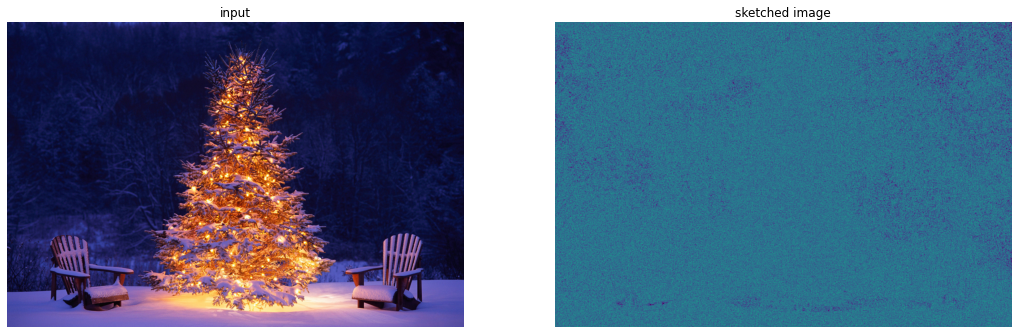

In [ ]:
#Sketch Filter with User Input 
#filter image 
def sketchFilter(image):
  img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  
  #sharpen 
  kernel_size = 11
  kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
  img_sharpen = cv2.filter2D(img_gray, -1, kernel)
  #canny edge 
  sketch = cv2.Canny(img_sharpen,10,20)
  plt.figure(figsize=(18, 8))
  plt.subplot(121)
  plt.imshow(image)
  plt.title('input')
  plt.axis('off')
  plt.subplot(122)
  plt.imshow(sketch)
  plt.title('sketched image')
  plt.axis('off')

sketchFilter(image)


In [ ]:
! wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz -O cifar-10-python.tar.gz
! tar -xzvf cifar-10-python.tar.gz

--2022-12-08 14:52:08--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  45.2MB/s    in 4.0s    

2022-12-08 14:52:13 (40.7 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [ ]:
 import numpy as np
import matplotlib.pyplot as plt
import cv2

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# read in batch-1 as training data
data_b1 = unpickle('cifar-10-batches-py/data_batch_1')
# each image is a 1D vector
train_im1d = data_b1[b'data']
train_im = train_im1d.reshape([train_im1d.shape[0],3,32,32]).transpose([0,2,3,1])
train_label = data_b1[b'labels']

# read in batch-2 as validation data
data_b2 = unpickle('cifar-10-batches-py/data_batch_2')
val_im1d = data_b2[b'data']
val_im = val_im1d.reshape([10000,3,32,32]).transpose([0,2,3,1])
val_label = data_b2[b'labels']

# read in batch-3 as training data for cartoon
data_b3 = unpickle('cifar-10-batches-py/data_batch_2')
train_im1d_cartoon = data_b1[b'data']
train_im_cartoon = train_im1d.reshape([train_im1d.shape[0],3,32,32]).transpose([0,2,3,1])
train_label_cartoon = data_b1[b'labels']


label_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

meta_file = r'cifar-10-batches-py/data_batch_1'
meta_data = unpickle(meta_file)
print(type(meta_data))
print(meta_data.keys()) 

<class 'dict'>
dict_keys([b'batch_label', b'labels', b'data', b'filenames'])


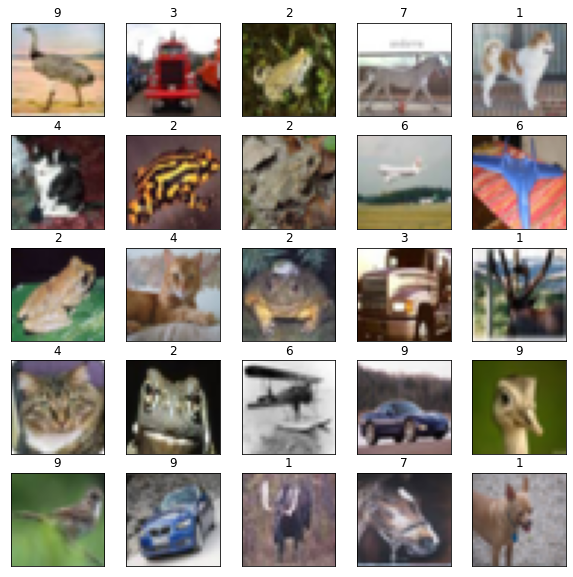

In [ ]:
#BLUR FILTER (Both Giulia and Mia)
#get imageas 
images = data_b1[b'data']
#reshape images 
images = images.reshape(len(images),3,32,32).transpose(0,2,3,1) 

#blur images and display 
for image in images:
	blur_image = cv2.GaussianBlur(image, (5,5), 5)

   


#FIGURE OUT HOW TO DISPLAY IMAGES- 
# dispaly random images
# define row and column of figure
rows, columns = 5, 5
# take random image idex id
imageId = np.random.randint(0, len(images), rows * columns)
# take images for above random image ids
images = images[imageId]
# take labels for these images only
label_names = meta_data[b'labels']
labels = data_b1[b'labels']
labels = [labels[i] for i in imageId]


# define figure
fig=plt.figure(figsize=(10, 10))
# visualize these random images
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(images[i-1])
    plt.xticks([])
    plt.yticks([])
    plt.title("{}"
          .format(label_names[labels[i-1]]))
plt.show()



In [ ]:
#CARTOON FILTER (Mia)
#get images 
images_cartoon = data_b3[b'data']
#reshape images 
images_cartoon = images_cartoon.reshape(len(images_cartoon),3,32,32).transpose(0,2,3,1) 

# Transform the image
  #blur images and display 
for image_cartoon in images_cartoon:
  #Converting to RGB
  image_cartoon = cv2.cvtColor(image_cartoon, cv2.COLOR_BGR2RGB)
  gray = cv2.cvtColor(image_cartoon, cv2.COLOR_BGR2GRAY)
  gray = cv2.medianBlur(gray, 5)
  edges = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 9, 9)
  color = cv2.bilateralFilter(image_cartoon, 9, 250, 250)
  image_cartoon = cv2.bitwise_and(color, color, mask=edges)


# dispaly random images
# define row and column of figure
rows, columns = 5, 5
# take random image idex id
imageId = np.random.randint(0, len(images_cartoon), rows * columns)
# take images for above random image ids
images = images_cartoon[imageId]
# take labels for these images only
label_names = meta_data[b'labels']
labels = data_b3[b'labels']
labels = [labels[i] for i in imageId]

# define figure
fig=plt.figure(figsize=(10, 10))
# visualize these random images
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(images[i-1])
    plt.xticks([])
    plt.yticks([])
    plt.title("{}"
          .format(label_names[labels[i-1]]))
plt.show()
  

  

	

SyntaxError: ignored

In [ ]:
#SKETCH FILTER (Giulia) 
#sketched image 
#get images 
#images_sketched = data_b7[b'data']
#reshape images 
#images_sketched= images_cartoon.reshape(len(images_cartoon),3,32,32).transpose(0,2,3,1) 

#for image_sketched in images_sketched:

#cv2 convert image to sketch 
image_sketch = data_b3[b'data']
#reshape images 
image_sketch = image_sketch.reshape(len(image_sketch),3,32,32).transpose(0,2,3,1) 

#sharpen 
kernel_size = 11
kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
image_sketch_sharpen = cv2.filter2D(image_sketch, -1, kernel)

#canny edge
t_lower = 50
t_upper = 150
image_sketch_canny = cv2.Canny(image_sketch_sharpen, t_lower, t_upper)

plt.imshow(image_sketch_canny, cmap = '')


error: ignored